# Training a CNN 

Modified by : Harold Mouchère + Nicolas Normand / University of Nantes

Date : 2023

Questions are at the end of the notebook.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

print("CUDA available :", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU name :", torch.cuda.get_device_name(0))
    print("GPUs available :", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Using CPU")

CUDA available : True
GPU name : NVIDIA GeForce GTX 1650 Ti
GPUs available : 1


## Preparation of the dataset
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Size of the mini batch:
minibatchsize = 32

# Load the full train set (60K samples)::
datadir = 'data'
fulltrainset = torchvision.datasets.MNIST(root=datadir, train=True, download=True, transform=transform)

# Split the full train part as train and validation (10K samples, some can be ignored):
trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [20000, 10000, 30000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize, shuffle=True, num_workers=0)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize, shuffle=False, num_workers=0)

# Load the test set:
testset = torchvision.datasets.MNIST(root=datadir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize, shuffle=False, num_workers=0)

# Define the set of class names:
classes = range(0,10)
nb_classes = len(classes)

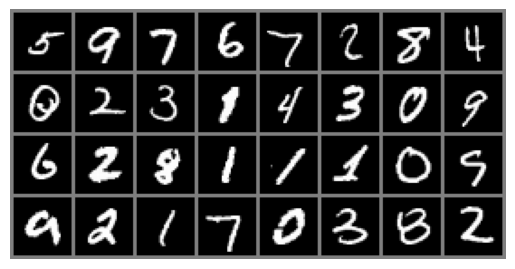

  5   9   7   6   7   2   8   4   0   2   3   1   4   3   0   9   6   2   8   1   1   1   0   9   9   2   1   7   0   3   8   2


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Functions to show an image
def displayDataAsImage(img, filename=''):
    img = img / 2 + 0.5 # Unnormalize
    numpy_img = img.numpy()
    plt.imshow(np.transpose(numpy_img, (1, 2, 0)))
    plt.axis('off')

    if filename == '':
        plt.show()
    else:
        plt.savefig(filename)

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
displayDataAsImage(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%3s' % classes[labels[j]] for j in range(minibatchsize)))

## Define a CNN

Propose a CNN constructor that takes meta-parameters as arguments (nb conv layers, nb kernel per conv, nb FC layers, nb hidden cells per fc)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# This class define the CNN architecture
# Default architecture is close to LeNet5 one
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

In [5]:
# Define the network to use
net = NetCNN()
net.to(device) # Move it to GPU or CPU

# Show the structure
print(net)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Define a Loss function and optimizer

In [6]:
import torch.optim as optim

# Let's use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Q1: Optimize the architecture

1. Reuse the training function from the previous TP
2. Analyse your network : recognition rate, confusion matrix 
3. Select one meta-paramter (or 2 depending on the available time) and draw the curve showing the loss depending  on this parameter
4. Evaluate and analyse the best network, compute the number of free parameters (complexity). See documentation of [nn.Module.parameters()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters).

In [2]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def loader_train_mnist(minibatchsize, trainset_size, validation_size):
    """
    Load the MNIST dataset and return the train and validation loaders and the train and validation set.
    """
    transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    fulltrainset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)

    trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [trainset_size, validation_size, (60000 - trainset_size - validation_size)])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize, shuffle=True, num_workers=0)
    validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize, shuffle=False, num_workers=0)

    return trainloader, validationloader, trainset, validationset

def loader_test_mnist(minibatchsize):
    """
    Load the MNIST test dataset and return the test loader and test set .
    """
    transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # Load the test set:
    testset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize, shuffle=False, num_workers=0)

    return testloader, testset

def train_model(model, minibatchsize, trainset_size, validation_size,
                num_epochs=5,
                val_check_batch_interval =200,
                criterion=nn.CrossEntropyLoss(),
                optimizer_fn=lambda params: optim.SGD(params, lr=0.001, momentum=0.9),
                device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    """
    Train the model using the specified parameters.
    """
    model.to(device)
    optimizer = optimizer_fn(model.parameters())

    trainloader, validationloader, trainset, validationset = loader_train_mnist(minibatchsize=minibatchsize, trainset_size=trainset_size, validation_size=validation_size)
    
    val_err_array = np.array([])
    train_err_array = np.array([])
    nb_sample_array = np.array([])

    best_val_loss = 1000000
    best_nb_sample = 0
    best_model = copy.deepcopy(model)

    nb_used_sample = 0
    running_loss = 0.0

    print('---- Training parameters --')
    print(f'Train set size : {trainset_size} | Validation set size : {validation_size}')
    print(f'Device : {device} | Batch size : {minibatchsize} | Epochs : {num_epochs} | Validation check batch interval : {val_check_batch_interval}')
    print('---- Model parameters -----')
    print(f'Optimizer : {optimizer.__class__.__name__} | Loss function : {criterion.__class__.__name__}')
    print('---- Training process -----')
    print(f'Start training the model...')
    for epoch in range(num_epochs):
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            nb_used_sample += minibatchsize
            running_loss += loss.item()

            if nb_used_sample % (val_check_batch_interval  * minibatchsize) == 0:
                train_err = (running_loss / (val_check_batch_interval  * minibatchsize))
                running_loss = 0.0

                total_val_loss = 0.0
                with torch.no_grad():
                    for val_data in validationloader:
                        val_images, val_labels = val_data
                        val_images, val_labels = val_images.to(device), val_labels.to(device)
                        val_outputs = model(val_images)
                        val_loss = criterion(val_outputs, val_labels)
                        total_val_loss += val_loss.item()
                val_err = (total_val_loss / len(validationset))

                train_err_array = np.append(train_err_array, train_err)
                val_err_array = np.append(val_err_array, val_err)
                nb_sample_array = np.append(nb_sample_array, nb_used_sample)

                if val_err < best_val_loss:
                    best_val_loss = val_err
                    best_nb_sample = nb_used_sample
                    best_model = copy.deepcopy(model)

        print(f'Epoch {epoch+1}/{num_epochs} took {time.time() - start_time:.2f}s - Train loss: {train_err:.3f} - Validation loss: {val_err:.3f}')
        print(f'Best validation loss: {best_val_loss:.4f} at {best_nb_sample} samples')

    print('Training complete!')
    return best_model, nb_sample_array, train_err_array, val_err_array, best_val_loss, best_nb_sample

def draw_loss_curves(nb_sample_array, train_err_array, val_err_array, best_nb_sample, best_val_loss):
    """
    Draw the loss curves for training and validation losses.
    """

    plt.clf()
    plt.xlabel('Samples seen')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.plot(nb_sample_array, val_err_array, 'b', label='Validation loss')
    plt.plot(nb_sample_array, train_err_array, 'r', label='Training loss')
    plt.plot([best_nb_sample], [best_val_loss], 'go', label='Best model')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, minibatchsize, 
                   device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    """
    Evaluate the model on the test set and print the accuracy.
    """
    model.to(device)
    correct = 0
    total = 0

    testloader, testset = loader_test_mnist(minibatchsize=minibatchsize)

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f'Accuracy of the network on the test images is : {accuracy:.2f}%')
    return accuracy

def count_trainable_parameters(model):
    """
    Count the number of trainable parameters in the model.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params:,}')
    return total_params

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class NetCNN3(nn.Module):
    def __init__(self):
        super(NetCNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=1 * 15 * 15, out_features=10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 1 * 15 * 15)
        x = self.fc1(x)
        return x
    
class NetCNN4(nn.Module):
    def __init__(self):
        super(NetCNN4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=4, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=1 * 4 * 4, out_features=10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 1 * 4 * 4)
        x = self.fc1(x)
        return x
    
class NetCNN5_3(nn.Module):
    def __init__(self):
        super(NetCNN5_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=3, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=1 * 5 * 5, out_features=10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 1 * 5 * 5)
        x = self.fc1(x)
        return x
    
class NetCNN5_1(nn.Module):
    def __init__(self):
        super(NetCNN5_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=1 * 14 * 14, out_features=10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 1 * 14 * 14)
        x = self.fc1(x)
        return x
    
class NetCNN6(nn.Module):
    def __init__(self):
        super(NetCNN6, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=6, stride=2, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=1 * 7 * 7, out_features=10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 1 * 7 * 7)
        x = self.fc1(x)
        return x

class NetCNN7_5(nn.Module):
    def __init__(self):
        super(NetCNN7_5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7, stride=5, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=1 * 3 * 3, out_features=10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 1 * 3 * 3)
        x = self.fc1(x)
        return x
    
class NetCNN7_1(nn.Module):
    def __init__(self):
        super(NetCNN7_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=1 * 13 * 13, out_features=10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 1 * 13 * 13)
        x = self.fc1(x)
        return x
    
class NetCNN8(nn.Module):
    def __init__(self):
        super(NetCNN8, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=8, stride=8, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=1 * 2 * 2, out_features=10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 1 * 2 * 2)
        x = self.fc1(x)
        return x
    
class NetCNN10(nn.Module):
    def __init__(self):
        super(NetCNN10, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=10, stride=2, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=1 * 6 * 6, out_features=10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 1 * 6 * 6)
        x = self.fc1(x)
        return x

Total trainable parameters: 471
---- Training parameters --
Train set size : 40000 | Validation set size : 20000
Device : cuda:0 | Batch size : 32 | Epochs : 1 | Validation check batch interval : 200
---- Model parameters -----
Optimizer : SGD | Loss function : CrossEntropyLoss
---- Training process -----
Start training the model...
Epoch 1/1 took 34.37s - Train loss: 0.015 - Validation loss: 0.015
Best validation loss: 0.0147 at 38400 samples
Training complete!
Accuracy of the network on the test images is : 86.98%


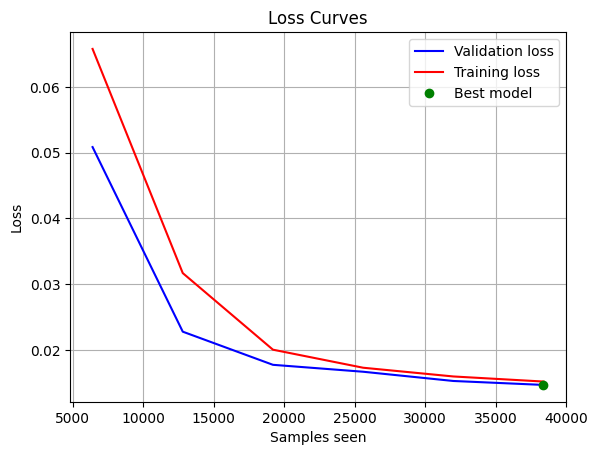

In [9]:
minibatchsize = 32
model = NetCNN10()
count_trainable_parameters(model)
best_model, nb_sample_array, train_err_array, val_err_array, best_val_loss, best_nb_sample = train_model(model, 
                                                                                                         minibatchsize=minibatchsize, 
                                                                                                         trainset_size=40000, 
                                                                                                         validation_size=20000,
                                                                                                         num_epochs=1,
                                                                                                         val_check_batch_interval=200,
                                                                                                         criterion=nn.CrossEntropyLoss(),
                                                                                                         optimizer_fn=lambda params: optim.SGD(params, lr=0.001, momentum=0.9))
evaluate_model(best_model, minibatchsize=minibatchsize)
draw_loss_curves(nb_sample_array, train_err_array, val_err_array, best_nb_sample, best_val_loss)

Training models...
Number of models to train: 9

/--/ Model : NetCNN3 /--/
---- Training parameters --
Train set size : 40000 | Validation set size : 20000
Device : cuda:0 | Batch size : 100 | Epochs : 10 | Validation check batch interval : 256
---- Model parameters -----
Optimizer : SGD | Loss function : CrossEntropyLoss
---- Training process -----
Start training the model...
Epoch 1/10 took 12.14s - Train loss: 0.018 - Validation loss: 0.010
Best validation loss: 0.0101 at 25600 samples
Epoch 2/10 took 15.87s - Train loss: 0.005 - Validation loss: 0.005
Best validation loss: 0.0048 at 76800 samples
Epoch 3/10 took 12.09s - Train loss: 0.004 - Validation loss: 0.004
Best validation loss: 0.0044 at 102400 samples
Epoch 4/10 took 15.72s - Train loss: 0.004 - Validation loss: 0.004
Best validation loss: 0.0040 at 153600 samples
Epoch 5/10 took 12.07s - Train loss: 0.004 - Validation loss: 0.004
Best validation loss: 0.0040 at 179200 samples
Epoch 6/10 took 15.30s - Train loss: 0.004 - Va

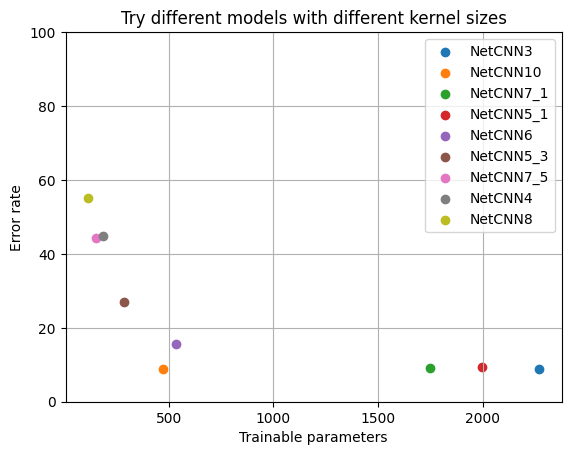

In [8]:
import matplotlib.pyplot as plt
import time

class_list = [NetCNN3, NetCNN4, NetCNN5_3, NetCNN5_1, NetCNN6, NetCNN7_5, NetCNN7_1, NetCNN8, NetCNN10]
minibatchsize = 100
results = []

# Loop over the models and train them
print("Training models...")
print("Number of models to train:", len(class_list))
start = time.time()
for model_class in class_list:
    model = model_class()
    print(f"\n/--/ Model : {model.__class__.__name__} /--/")
    best_model, _, _, _, _, _ = train_model(model, 
        minibatchsize=minibatchsize, 
        trainset_size=40000, 
        validation_size=20000,
        num_epochs=10,
        val_check_batch_interval=256,
        criterion=nn.CrossEntropyLoss(),
        optimizer_fn=lambda params: optim.SGD(params, lr=0.001, momentum=0.9)
    )
    trainable_params = count_trainable_parameters(model)
    accuracy = evaluate_model(best_model, minibatchsize=minibatchsize)
    results.append((model.__class__.__name__, trainable_params, 100 - accuracy))
print("Training completed in", time.time() - start, "seconds")

plt.clf()
plt.xlabel('Trainable parameters')
plt.ylabel('Error rate')
plt.title('Try different models with different kernel sizes')
plt.grid(True)
plt.ylim(0, 100)
sorted_results = sorted(results, key=lambda x: x[2], reverse=False)
for model_name, trainable_params, error_rate in sorted_results:
    plt.scatter(trainable_params, error_rate, label=model_name)
plt.legend()
plt.show()    

Training models...
Number of models to train: 9

/--/ Model : NetCNN10 /--/
---- Training parameters --
Train set size : 40000 | Validation set size : 20000
Device : cuda:0 | Batch size : 32 | Epochs : 10 | Validation check batch interval : 1250
---- Model parameters -----
Optimizer : SGD | Loss function : CrossEntropyLoss
---- Training process -----
Start training the model...
Epoch 1/10 took 16.18s - Train loss: 0.028 - Validation loss: 0.015
Best validation loss: 0.0152 at 40000 samples
Epoch 2/10 took 15.43s - Train loss: 0.013 - Validation loss: 0.013
Best validation loss: 0.0131 at 80000 samples
Epoch 3/10 took 15.19s - Train loss: 0.012 - Validation loss: 0.012
Best validation loss: 0.0122 at 120000 samples
Epoch 4/10 took 15.79s - Train loss: 0.012 - Validation loss: 0.012
Best validation loss: 0.0120 at 160000 samples
Epoch 5/10 took 16.48s - Train loss: 0.011 - Validation loss: 0.012
Best validation loss: 0.0117 at 200000 samples
Epoch 6/10 took 15.65s - Train loss: 0.011 - V

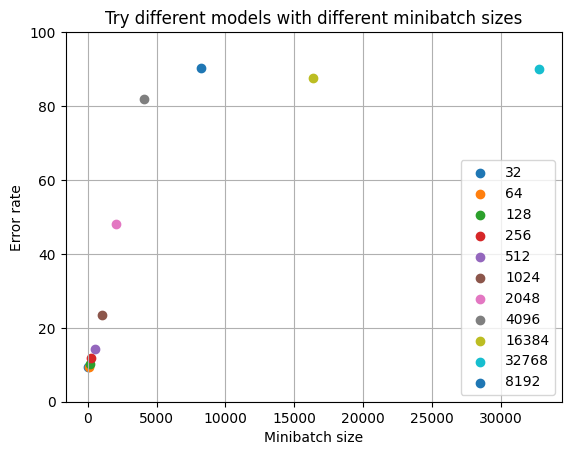

In [18]:
import matplotlib.pyplot as plt
import time

minibatchsize_list = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
results = []

# Loop over the models and train them
print("Training models...")
print("Number of models to train:", len(class_list))
start = time.time()
for minibatchsize in minibatchsize_list:
    model = NetCNN10()
    print(f"\n/--/ Model : {model.__class__.__name__} /--/")
    best_model, _, _, _, _, _ = train_model(model, 
        minibatchsize=minibatchsize, 
        trainset_size=40000, 
        validation_size=20000,
        num_epochs=10,
        val_check_batch_interval=int(40000 / minibatchsize),
        criterion=nn.CrossEntropyLoss(),
        optimizer_fn=lambda params: optim.SGD(params, lr=0.001, momentum=0.9)
    )
    accuracy = evaluate_model(best_model, minibatchsize=minibatchsize)
    results.append((minibatchsize, 100 - accuracy))
print("Training completed in", time.time() - start, "seconds")

plt.clf()
plt.xlabel('Minibatch size')
plt.ylabel('Error rate')
plt.title('Try different models with different minibatch sizes')
plt.grid(True)
plt.ylim(0, 100)
sorted_results = sorted(results, key=lambda x: x[1], reverse=False)
for minibatchsize, error_rate in sorted_results:
    plt.scatter(minibatchsize, error_rate, label=minibatchsize)
plt.legend()
plt.show()    